<a href="https://colab.research.google.com/github/MrCogito/SpecGan/blob/main/Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generate spectrogram**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import os
import librosa
import librosa.display
import IPython.display as ipd
import soundfile

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Inzynierka/Datasets/drums/drums.zip > /dev/null 

# Set parameters


In [28]:
audio_folder = '/content/audio'
dataset_tensor_folder = '/content/gdrive/MyDrive/Inzynierka/Models/vctk_female/dataset'
#audio_trim_folder = '/content/gdrive/MyDrive/Inzynierka/Data_new/audio_trim_folder/'
dataset_tensor = np.empty((0,128,44))

TARGET_SIZE = 16000                     
TARGET_SAMPLING_RATE=8000
#spectrogram_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_mel_spectrogram_256_8_3.npy')

# Create spectrograms


In [34]:
#Create spectrograms

for root, dirs, files in os.walk(audio_folder):
  for name in files:
    print(name)
    if name.endswith("flac"):
      audio_file, sr = librosa.load(os.path.join(root,name))  
      print(sr)                                                                                                        
      #print(audio_file.dtype)
      #audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                          # Trim silnce with threshold equal to 15dB
      audio_file_trim_4k = librosa.resample(audio_file, sr, target_sr = sr)                                            # resample TARGET_SAMPLING_RATE
      audio_fix_length = librosa.util.fix_length(audio_file_trim_4k, 2*sr, axis=- 1)                                   # get same length in all clip, zero padding  
      Spectrogram = librosa.feature.melspectrogram(audio_fix_length, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)   #create Mel spectrogram
      S_DB = librosa.power_to_db(Spectrogram, ref=np.max)
      tensor_spectrogram = tf.convert_to_tensor(S_DB)                                                                  # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      print(tensor_spectrogram.shape) 
      dataset_tensor = tf.concat([dataset_tensor, tensor_spectrogram], 0)

np.save(os.path.join(dataset_tensor_folder , "Female_test"), dataset_tensor)


p225_001_mic1.flac
22050
(1, 128, 44)
p225_059_mic2.flac
22050
(1, 128, 44)


In [ ]:
#Create spectrograms

i=0
for root, dirs, files in os.walk(audio_folder):
  for name in files:
   
    if name.endswith("wav"):
      #print(os.path.join(root,name))
      audio_file, sr = librosa.load(os.path.join(root,name))                                                       
      #print(audio_file.dtype)
      #audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                      # Trim silnce with threshold equal to 15dB
      audio_file_fix_length = librosa.util.fix_length(audio_file, sr*2, axis=- 1)                                  # get same length in all clips  (2s)   
      spectrogram = np.abs(librosa.stft(audio_file_fix_length,n_fft=2046, hop_length=700))                         # create spectrogram.  n_fft size set to 510 to get 256 x n shape of spectrogram  
      tensor_spectrogram = tf.convert_to_tensor(spectrogram)                                                       # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      #print(tensor_spectrogram.shape)
      dataset_tensor = tf.concat([dataset_tensor,tensor_spectrogram], 0)
      print(dataset_tensor.shape) 
      #print(i)
      #i = i+1


np.save(os.path.join(dataset_tensor_folder , "spectrogram_tensor_drums_abs"), dataset_tensor)


## Mel-Spectrograms to audio 


(2, 128, 44)
(44032,)


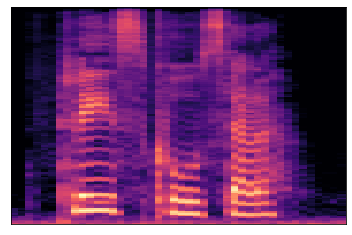

In [51]:
### REAL 

loaded = np.load('/content/gdrive/MyDrive/Inzynierka/Models/vctk_female/dataset/Female_test.npy')
print(loaded.shape)
#loaded = loaded.reshape(16,256,8)
#loaded = (loaded *80)-80
#S_DB = librosa.power_to_db(S, ref=np.max)
spec_gen = loaded[0]
librosa.display.specshow(spec_gen)
P = librosa.db_to_power(spec_gen, ref=1.0)
S = librosa.feature.inverse.mel_to_stft(P,sr=22050, n_fft=4096)
y = librosa.griffinlim(S)
print(y.shape)
ipd.Audio(y, rate=22050)

# Spectrograms to audio 


(160, 1024, 64)
float32
323.09225
4.9477566e-14


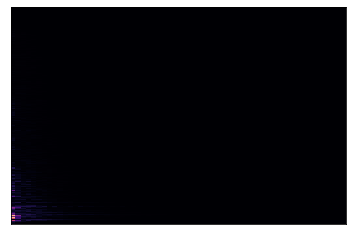

In [ ]:
### REAL

loaded_real = np.load('/content/drive/MyDrive/Inzynierka/Datasets/drums/spectrogram_tensor_drums.npy')

#loaded_real = np.load('/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/v1_250.npy')
print(loaded_real.shape)
print(loaded_real.dtype)
spec = loaded_real[130]
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec)
ipd.Audio(audio, rate=22050)
print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)
